# Jena Climate Dataset Exploratory Data Analsys

This notebook exploits the Jena Climate Dataset aiming to extract useful information to implement predictive models on the temperature.

In [1]:
import os
import warnings
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy.signal import periodogram
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')
plt.rc('figure', figsize=(15, 10))

In [2]:
DATA_ROOT = Path('data/')

## Data Loading

In [3]:
jena_df = pd.read_csv(DATA_ROOT / 'jena_climate_2009_2016.csv', parse_dates=['Date Time'], na_values=['-9999.0'], index_col='Date Time')
jena_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
jena_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420533 non-null  float64
 12  max. wv (m/s)    420531 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [5]:
jena_df.describe().round(2)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.00,420551.00,420551.00,420551.00,420551.00,420551.00,420551.00,420551.00,420551.00,420551.00,420551.00,420533.00,420531.00,420551.00
mean,989.21,9.45,283.49,4.96,76.01,13.58,9.53,4.04,6.02,9.64,1216.06,2.13,3.53,174.74
std,8.36,8.42,8.50,6.73,16.48,7.74,4.18,4.90,2.66,4.24,39.98,1.54,2.34,86.68
min,913.60,-23.01,250.60,-25.01,12.95,0.95,0.79,0.00,0.50,0.80,1059.45,0.00,0.00,0.00
25%,984.20,3.36,277.43,0.24,65.21,7.78,6.21,0.87,3.92,6.29,1187.49,0.99,1.76,124.90
50%,989.58,9.42,283.47,5.22,79.30,11.82,8.86,2.19,5.59,8.96,1213.79,1.76,2.96,198.10
75%,994.72,15.47,289.53,10.07,89.40,17.60,12.35,5.30,7.80,12.49,1242.77,2.86,4.74,234.10
max,1015.35,37.28,311.34,23.11,100.00,63.77,28.32,46.01,18.13,28.82,1393.54,28.49,23.50,360.00


In [6]:
# select numerical columns
jena_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: normaltest(x).pvalue < 0.05, axis=0)

p (mbar)            True
T (degC)            True
Tpot (K)            True
Tdew (degC)         True
rh (%)              True
VPmax (mbar)        True
VPact (mbar)        True
VPdef (mbar)        True
sh (g/kg)           True
H2OC (mmol/mol)     True
rho (g/m**3)        True
wv (m/s)           False
max. wv (m/s)      False
wd (deg)            True
dtype: bool

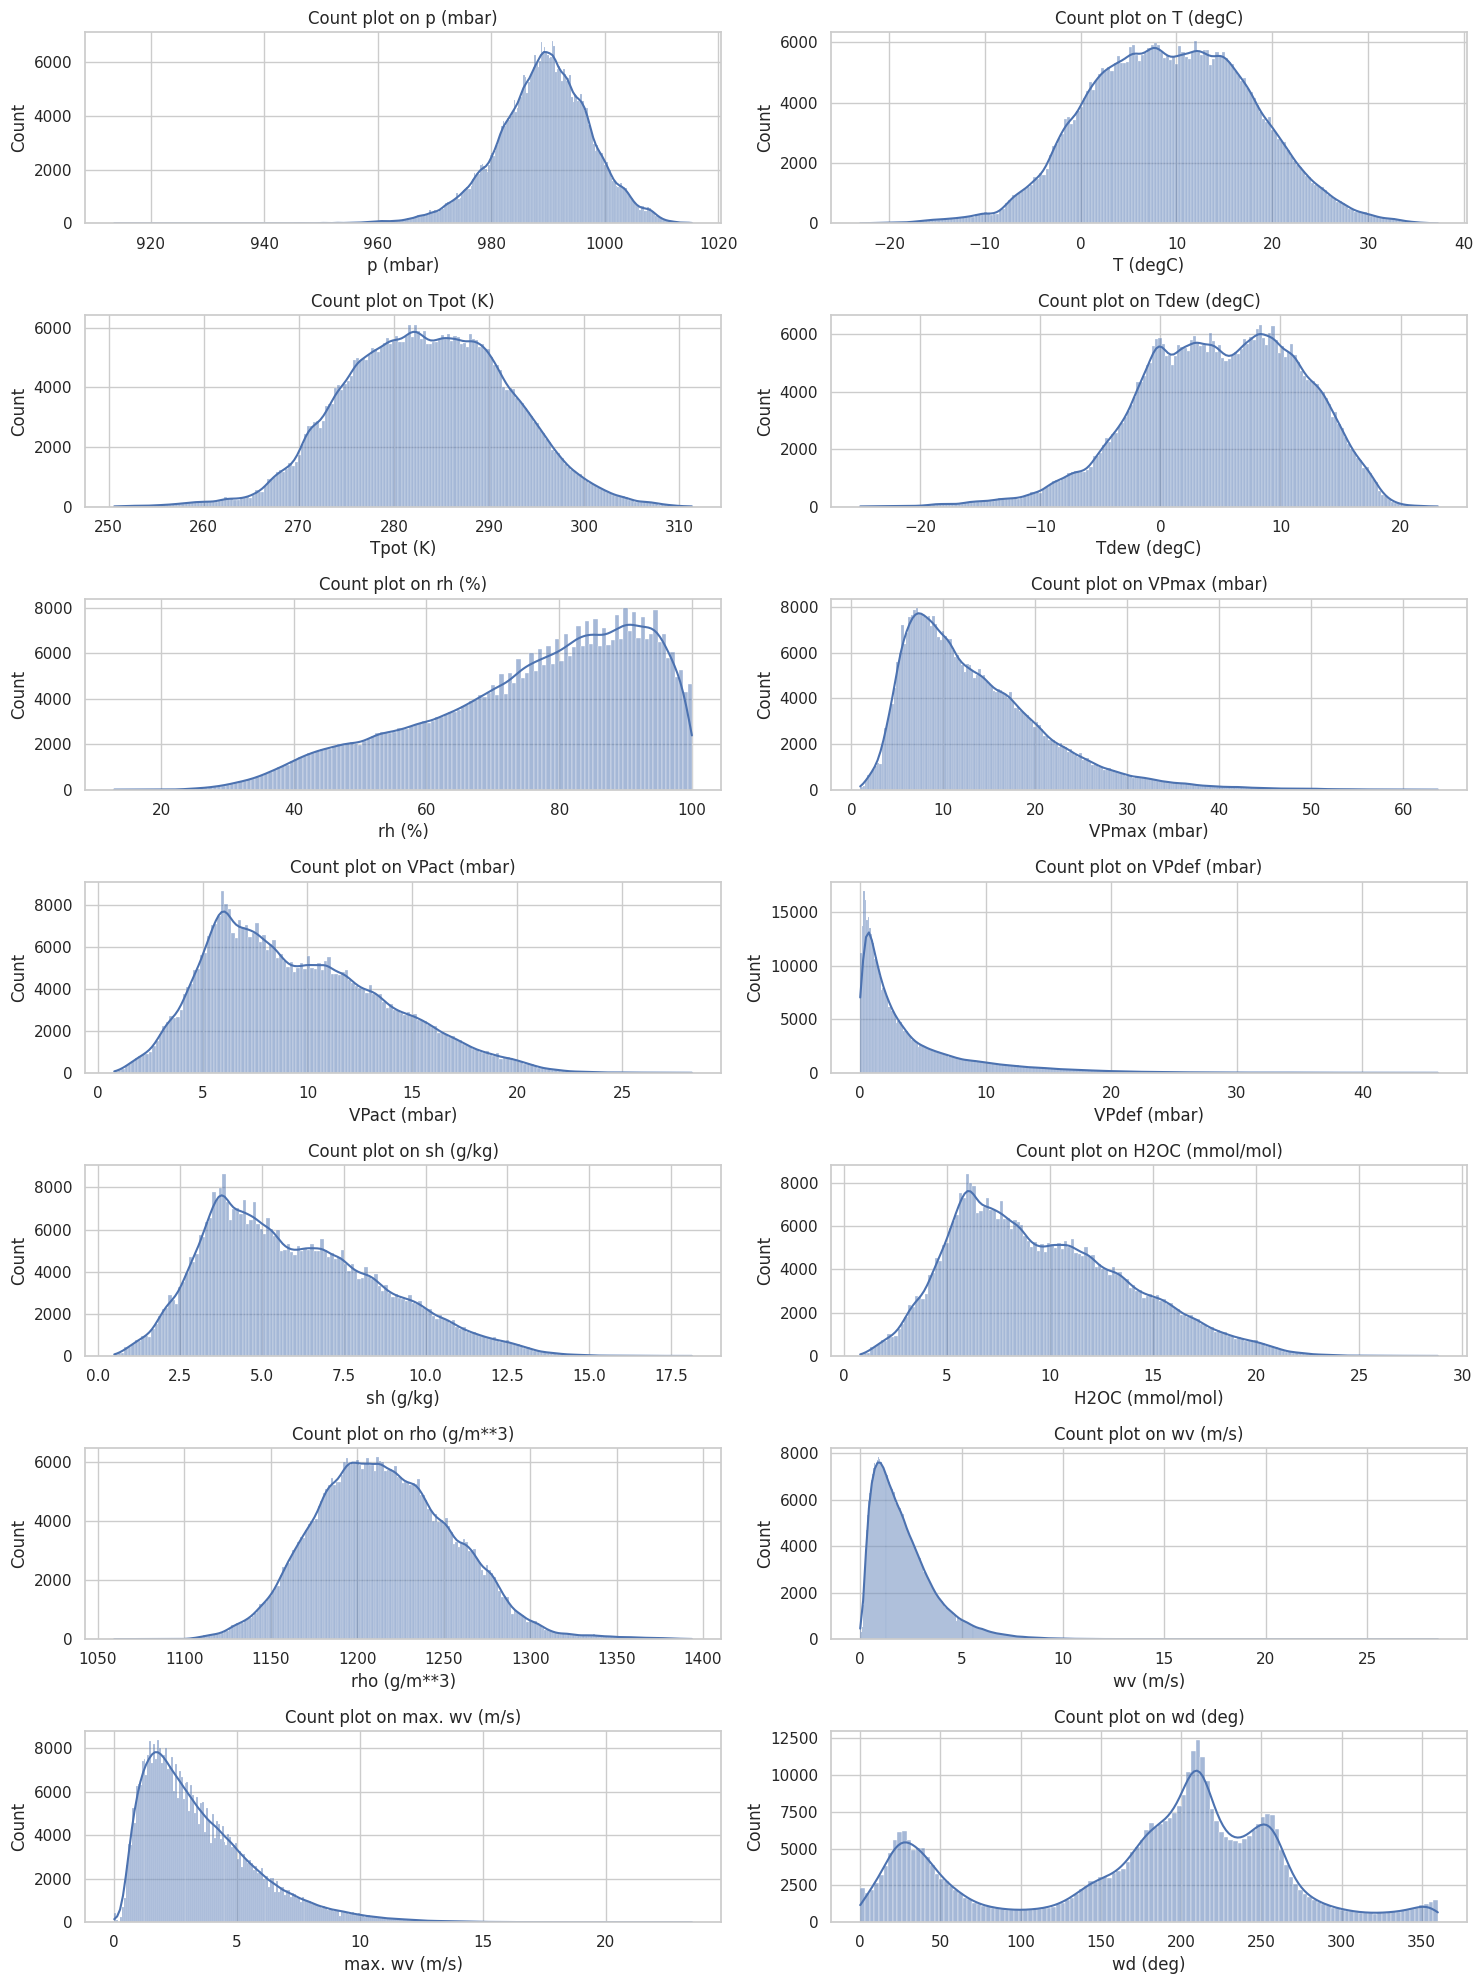

In [7]:
fig, axes = plt.subplots(7, 2, figsize=(15, 20))
for i, col in enumerate(jena_df.columns):
    sns.histplot(jena_df[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Count plot on {col}')

plt.tight_layout()
plt.show()

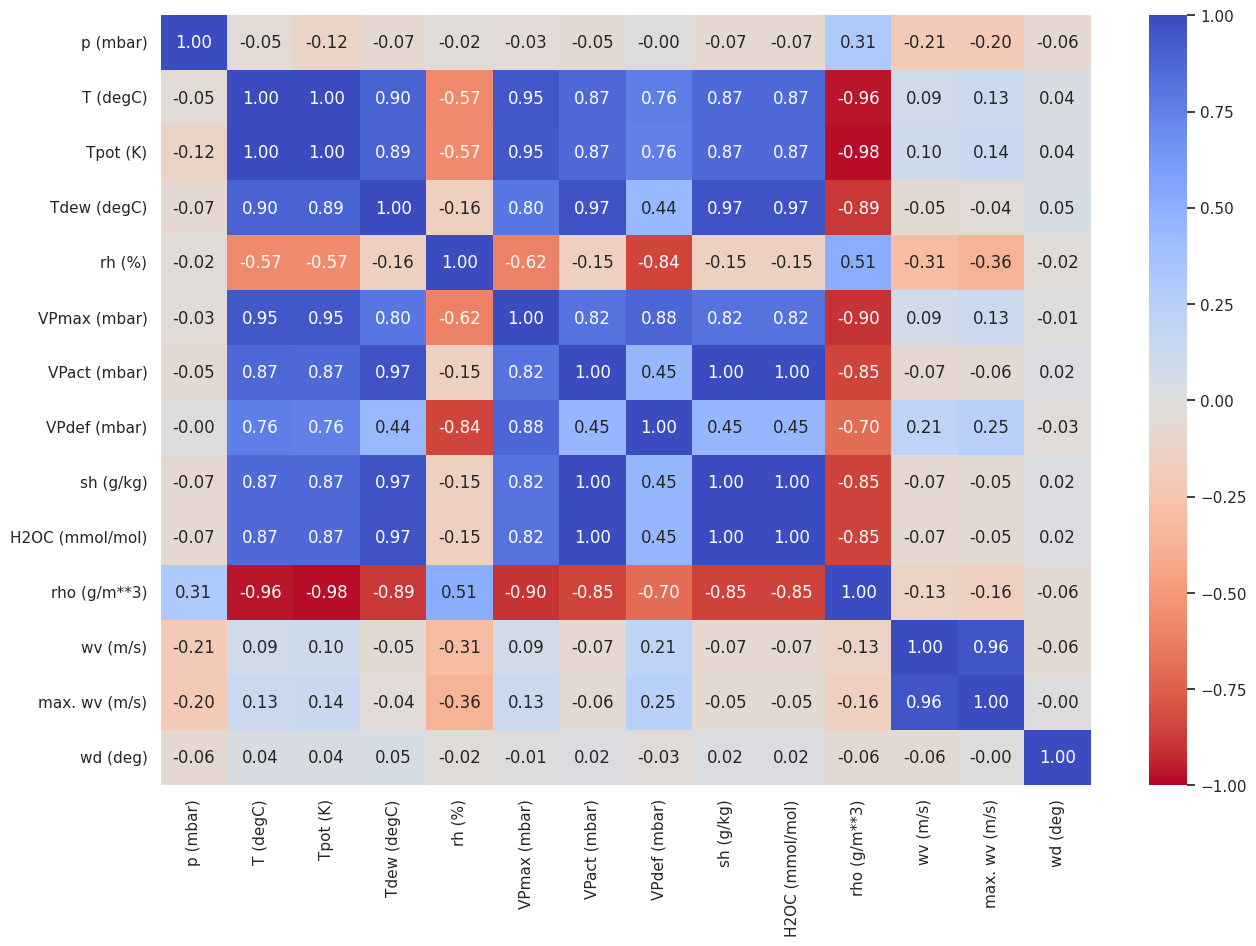

In [8]:
corr = jena_df.corr()
sns.heatmap(corr, annot=True, vmin=-1.0, fmt='.2f', cmap='coolwarm_r')
plt.show()  

In [5]:
features_df = jena_df.dropna()
target = features_df['T (degC)']

features_df = features_df.drop(columns=['T (degC)', 'Tpot (K)'])

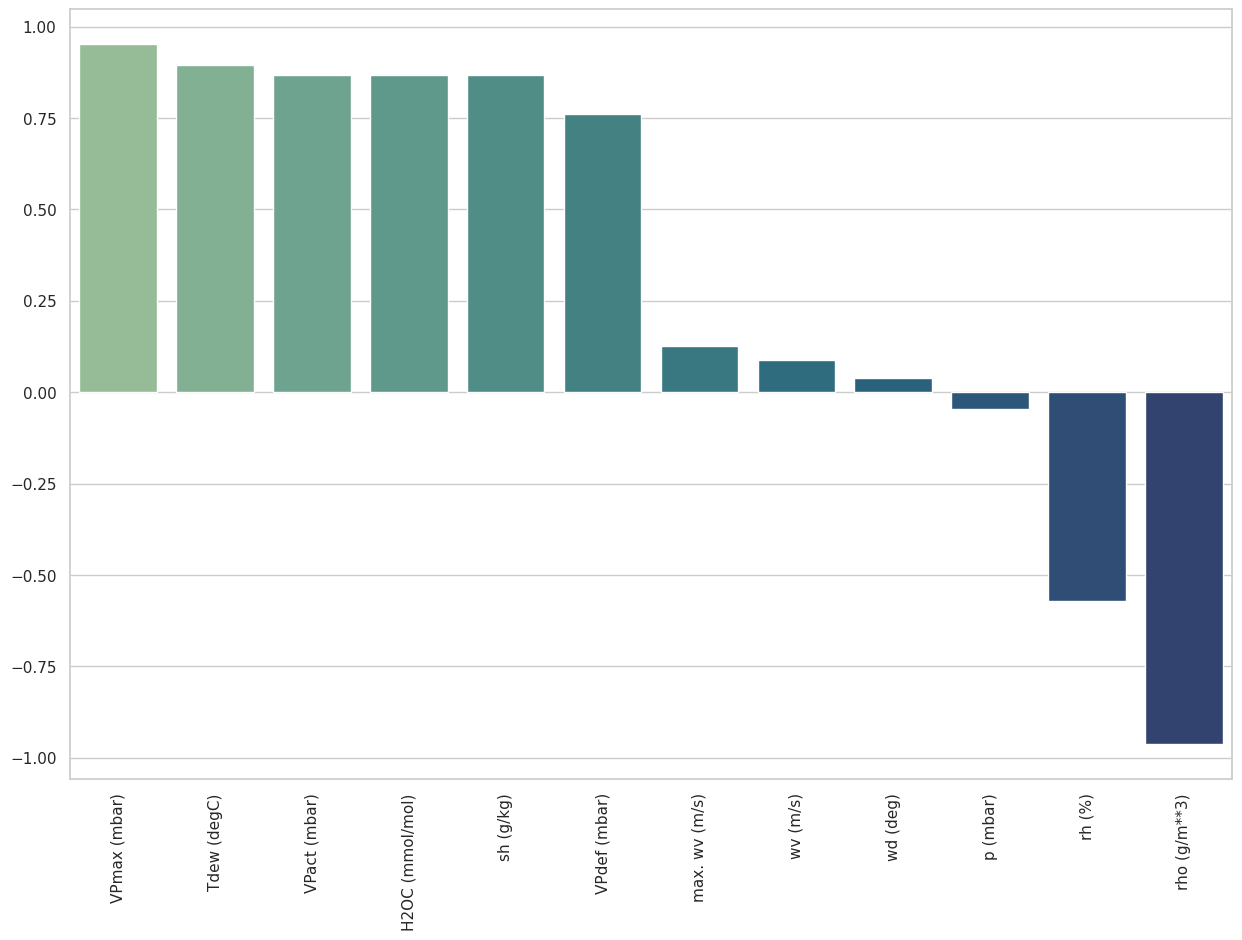

In [10]:
corr = features_df.apply(lambda x: x.corr(target))
corr = corr.sort_values(ascending=False)
sns.barplot(x=corr.index, y=corr.values, palette='crest')
plt.xticks(rotation=90)
plt.show()

In [11]:
mi = mutual_info_regression(features_df, target)
mi = pd.Series(mi, index=features_df.columns)
mi.sort_values(ascending=False, inplace=True)

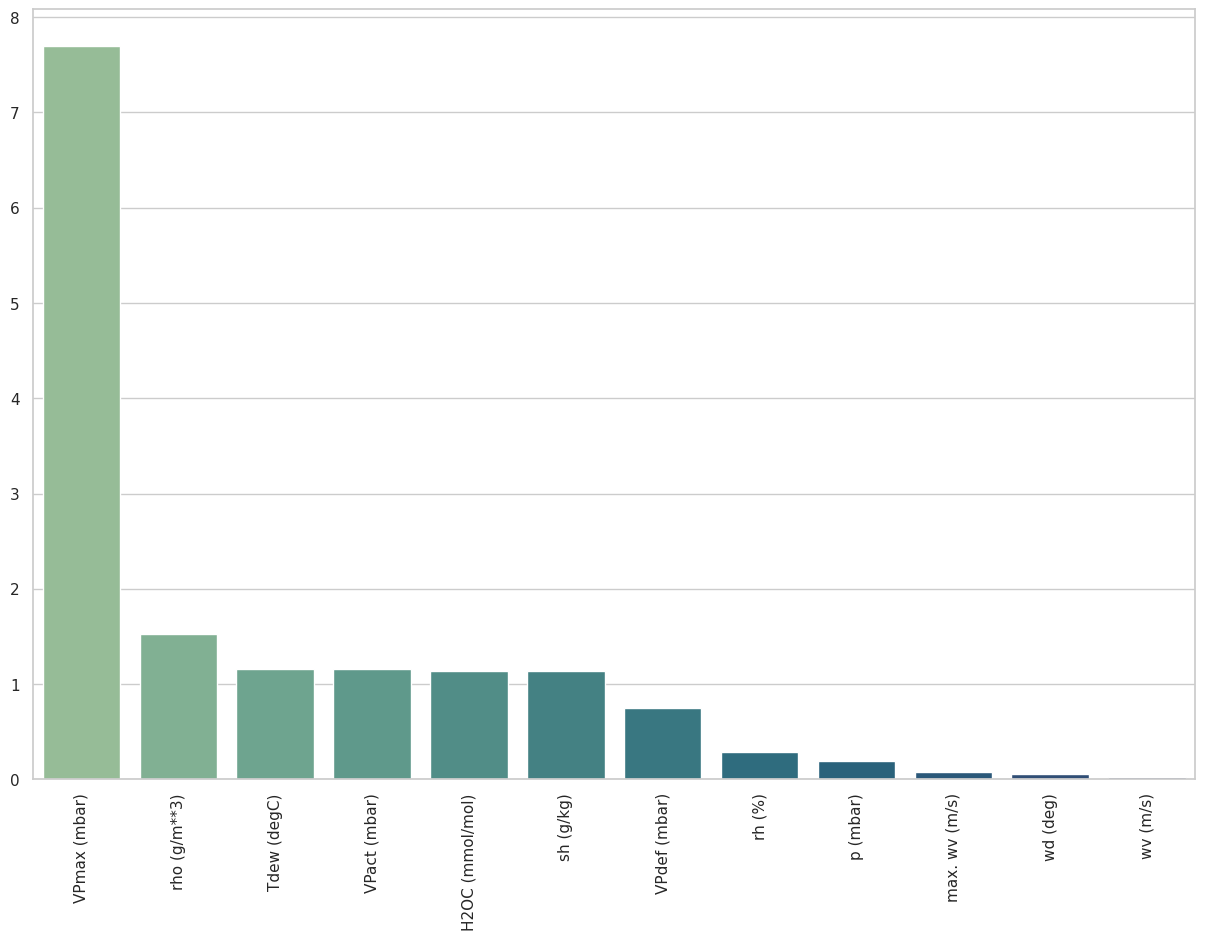

In [12]:
sns.barplot(x=mi.index, y=mi.values, palette='crest')
plt.xticks(rotation=90)
plt.show()

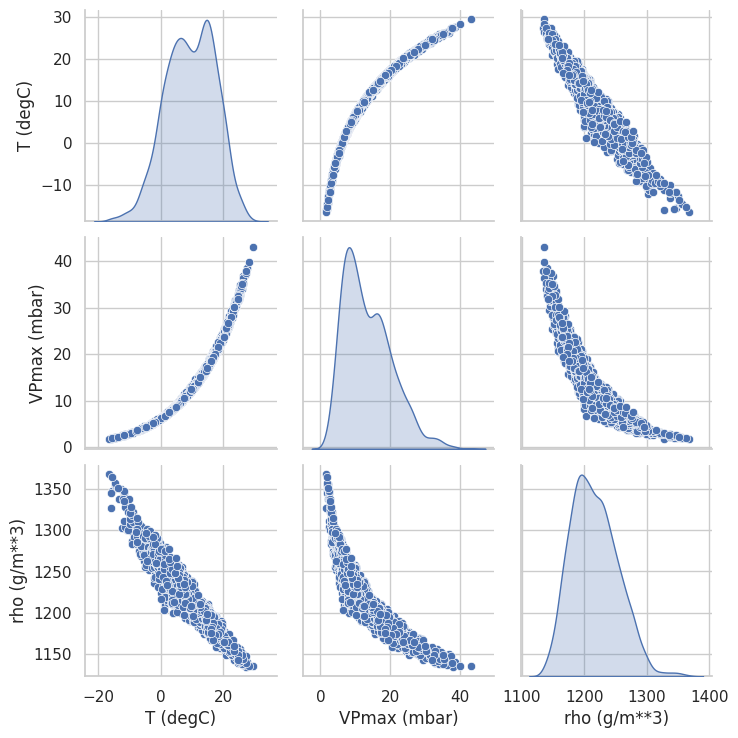

In [13]:
sns.pairplot(jena_df.resample(rule='D').mean(), vars=['T (degC)', 'VPmax (mbar)', 'rho (g/m**3)'], diag_kind='kde')
plt.show()

In [6]:
pca = PCA(n_components=features_df.shape[1])
pca.fit(features_df)

for component in range(features_df.shape[1]):
    print(f'Component {component + 1:2d} explains {pca.explained_variance_ratio_[component]:.2%} of the variance')


Component  1 explains 78.08% of the variance
Component  2 explains 18.74% of the variance
Component  3 explains 2.25% of the variance
Component  4 explains 0.75% of the variance
Component  5 explains 0.10% of the variance
Component  6 explains 0.06% of the variance
Component  7 explains 0.03% of the variance
Component  8 explains 0.00% of the variance
Component  9 explains 0.00% of the variance
Component 10 explains 0.00% of the variance
Component 11 explains 0.00% of the variance
Component 12 explains 0.00% of the variance


In [42]:
adf_result = adfuller(target, maxlag=30)
kpss_result = kpss(target)

print(f'ADF Statistic: {adf_result[0]:.5f}')
print(f'p-value: {adf_result[1]:.5f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.5f}')

print(f'\nKPSS Statistic: {kpss_result[0]:.5f}')
print(f'p-value: {kpss_result[1]:.5f}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'\t{key}: {value:.5f}')

if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print('\nThe time series is stationary')
elif adf_result[1] > 0.05 and kpss_result[1] < 0.05:
    print('\nThe time series is trend stationary')
elif adf_result[1] < 0.05 and kpss_result[1] < 0.05:
    print('\nThe time series is difference stationary')
else:
    print('\nThe time series is not stationary')

ADF Statistic: -2.30711
p-value: 0.16968
Critical Values:
	1%: -3.43261
	5%: -2.86254
	10%: -2.56730

KPSS Statistic: 0.44561
p-value: 0.05750
Critical Values:
	10%: 0.34700
	5%: 0.46300
	2.5%: 0.57400
	1%: 0.73900

The time series is not stationary


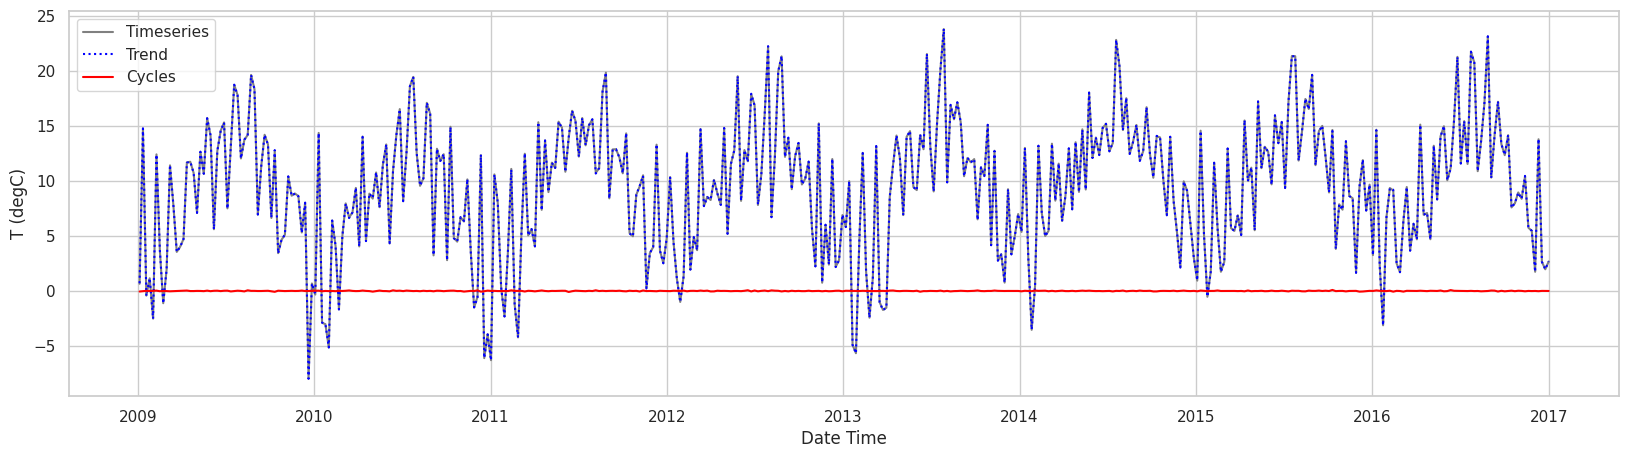

In [16]:
cycle, trend = hpfilter(target, lamb=129600)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=target.resample(rule='W').mean(), label='Timeseries', color='gray', ax=ax)
sns.lineplot(data=trend.resample(rule='W').mean(), label='Trend', linestyle='dotted', color='blue', ax=ax)
sns.lineplot(data=cycle.resample(rule='W').mean(), label='Cycles', color='red', ax=ax)
ax.legend()
plt.show()

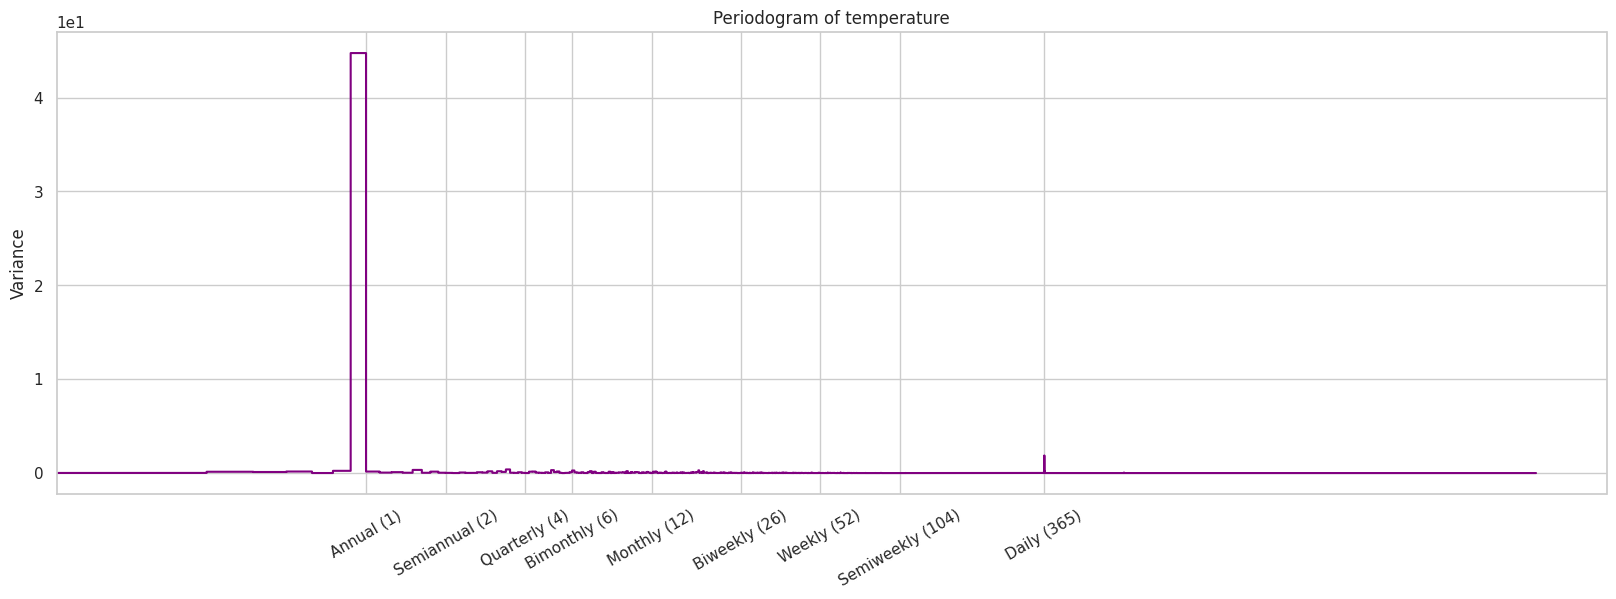

In [17]:
fs = pd.Timedelta('1y') / pd.Timedelta('10min')

frequencies, spectrum = periodogram(
    target.values,
    fs=fs,
    scaling='spectrum',
    window='boxcar',
    detrend='linear'
)

plt.figure(figsize=(20, 6))
plt.title('Periodogram of temperature')
plt.step(frequencies, spectrum, color='purple')
plt.xscale('log')
plt.xticks(
    [1, 2, 4, 6, 12, 26, 52, 104, 365],
    labels=[
        'Annual (1)',
        'Semiannual (2)',
        'Quarterly (4)',
        'Bimonthly (6)',
        'Monthly (12)',
        'Biweekly (26)',
        'Weekly (52)',
        'Semiweekly (104)',
        'Daily (365)',
    ],
    rotation=30,
)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylabel('Variance')
plt.show()

Analysis: Annual and daily seasonality.

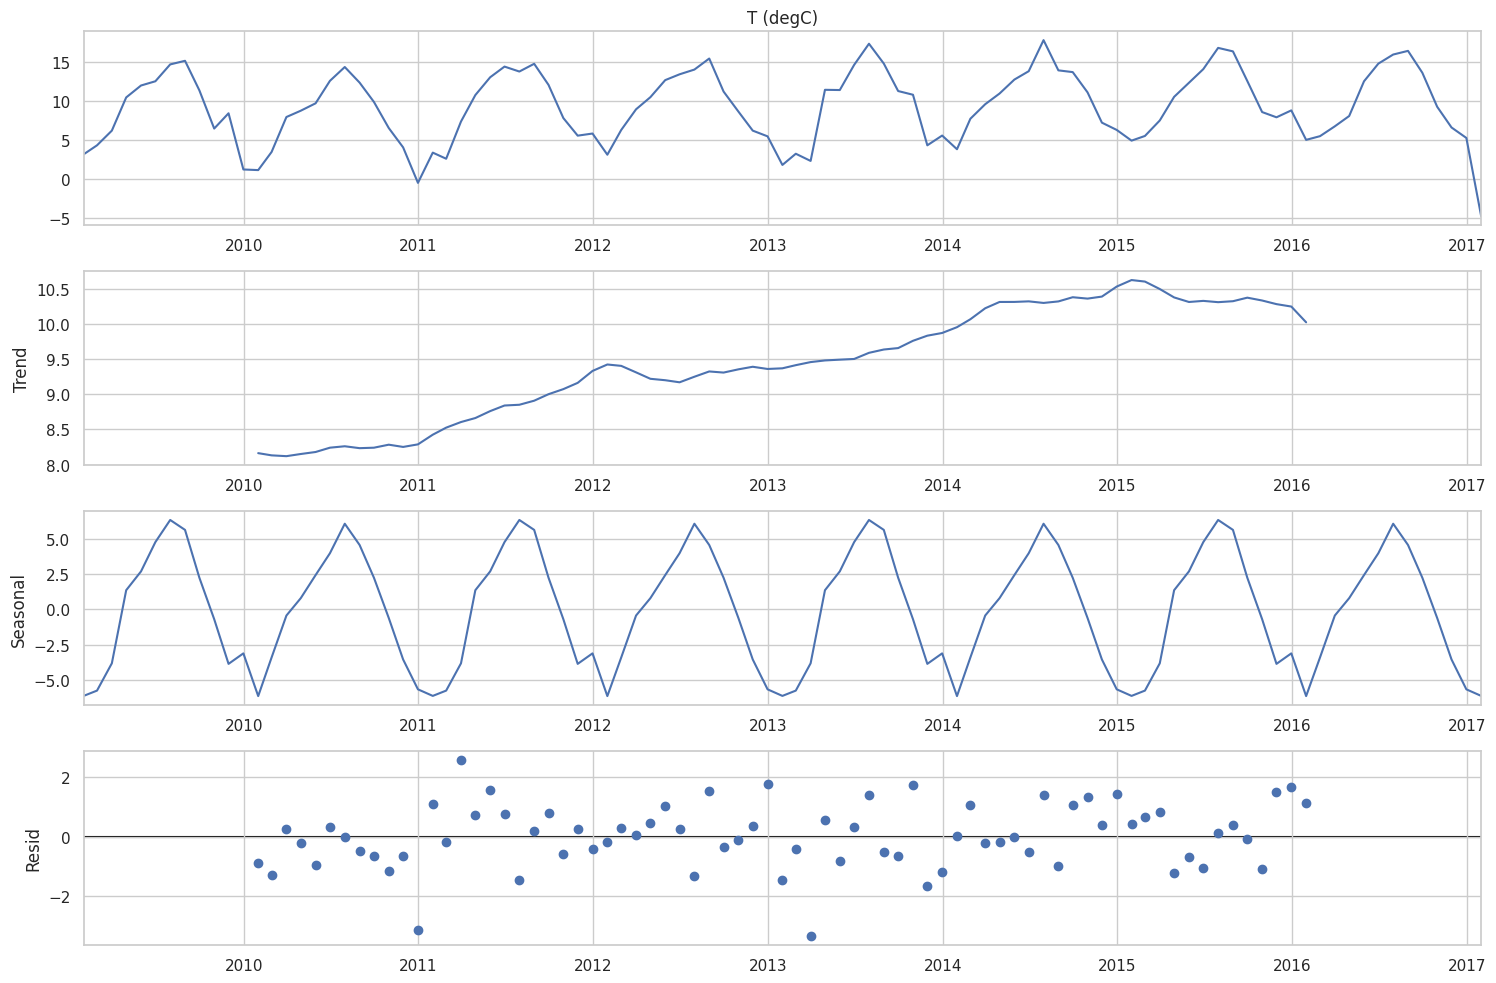

In [18]:
seasonal_decompose(jena_df.resample(rule='M')['T (degC)'].mean().dropna(), model='additive', period=24).plot();

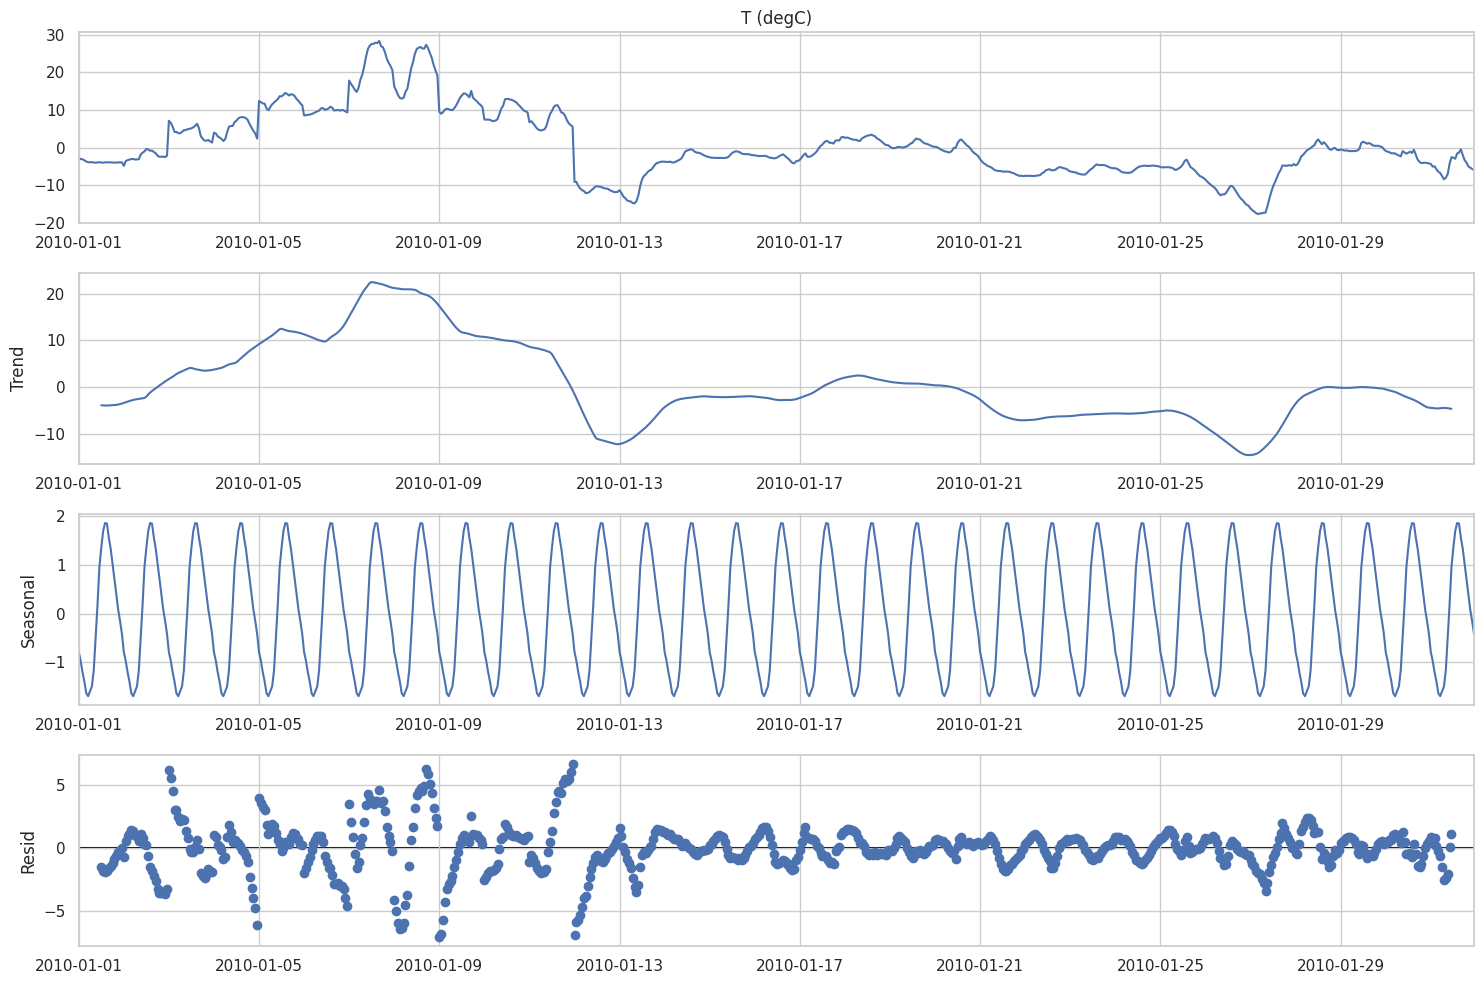

In [19]:
hourly_df = jena_df.resample(rule='H')['T (degC)'].mean().dropna()
hourly_df = hourly_df['2010-01-01':'2010-01-31']

seasonal_decompose(hourly_df, model='additive', period=24).plot();

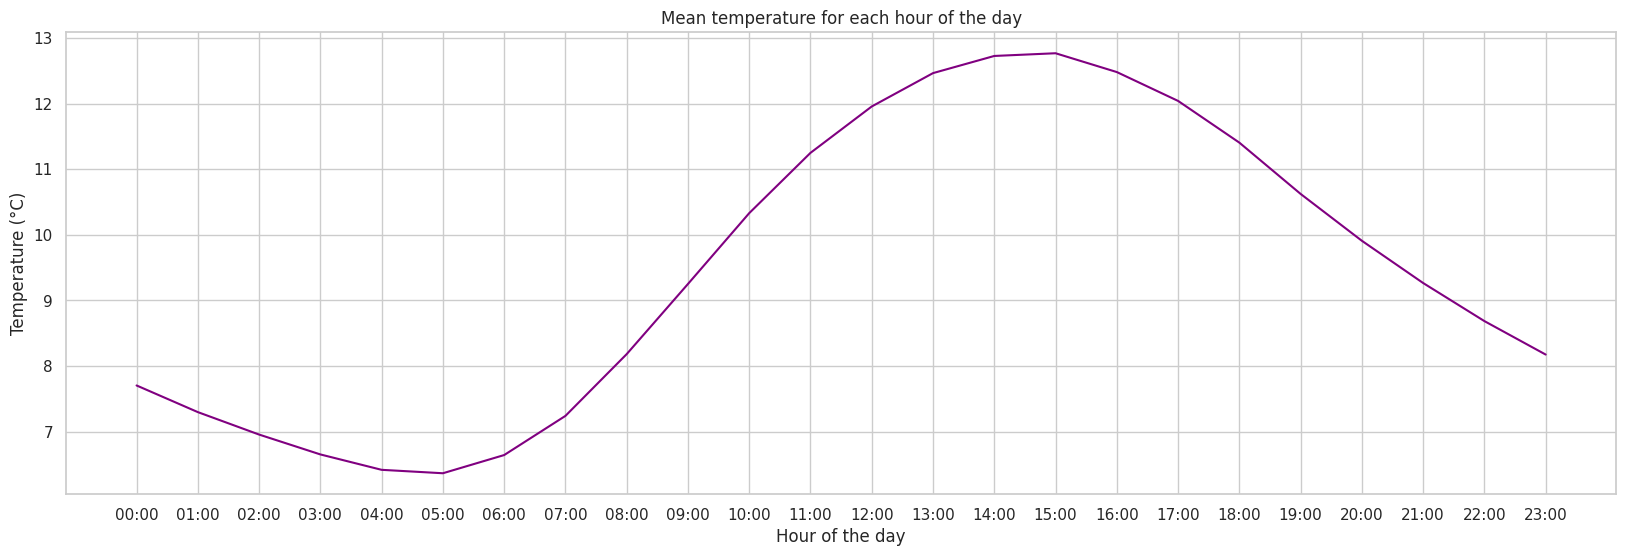

In [20]:
hourly_mean = jena_df.groupby(jena_df.index.hour)['T (degC)'].mean()

# Plot the mean temperature for each hour of the day
plt.figure(figsize=(20, 6))
plt.title('Mean temperature for each hour of the day')
plt.plot(hourly_mean.index, hourly_mean.values, color='purple')
plt.xticks(hourly_mean.index)
plt.xlabel('Hour of the day')
plt.xticks(range(0, 24), labels=[f'{i:02d}:00' for i in range(0, 24)])
plt.ylabel('Temperature (°C)')
plt.show()

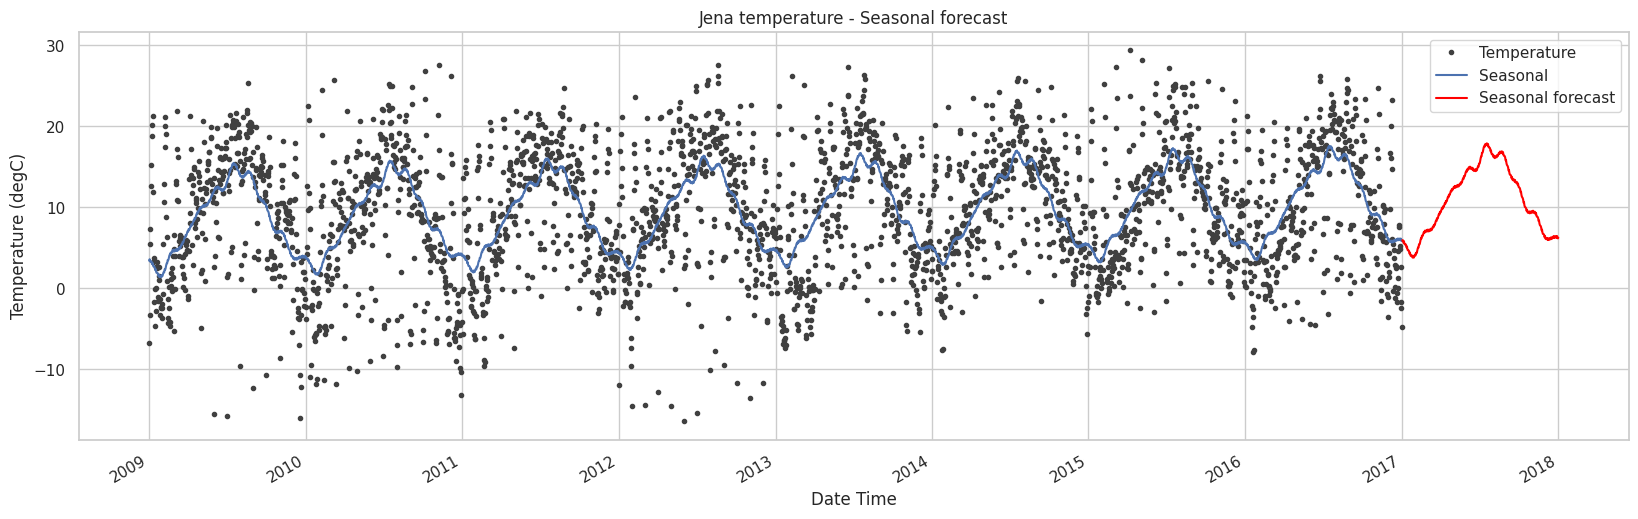

In [21]:
fourier = CalendarFourier(freq='A', order=10)

daily_df = jena_df.resample(rule='D').mean()
target = daily_df['T (degC)'].dropna()

dp = DeterministicProcess(
    index=daily_df.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X = X.loc[target.index]

model = LinearRegression(fit_intercept=False)
model.fit(X, target)

y_pred = pd.Series(model.predict(X), index=target.index)
X_fore = dp.out_of_sample(steps=365)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = target.plot(color='0.25', style='.', title='Jena temperature - Seasonal forecast', label='Temperature', figsize=(20, 6))
ax = y_pred.plot(ax=ax, label='Seasonal')
ax = y_fore.plot(ax=ax, label='Seasonal forecast', color='red')
ax.set_ylabel('Temperature (degC)')
ax.legend()

plt.show()

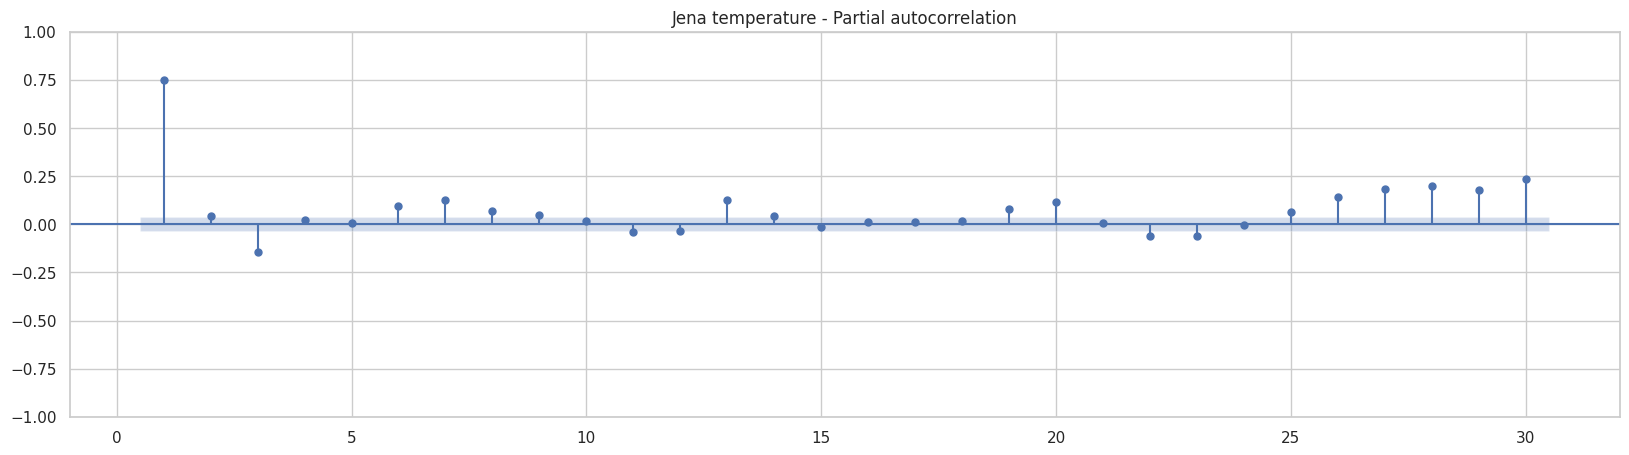

In [62]:
plt.rc('figure', figsize=(20, 5))
plot_pacf(target.resample(rule='D').mean().dropna(), lags=30, method='ywm', zero=False, title='Jena temperature - Partial autocorrelation');
plt.rc('figure', figsize=(15, 10))

In [56]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x

    x_.dropna(inplace=True)
    y_ = y_.loc[x_.index]

    mi = mutual_info_regression(x_.values.reshape(-1, 1), y_.values)
    
    corr = y_.corr(x_)
        
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f'Corr: {corr:.2f}\nMI:{mi[0]:.2f}',
        prop=dict(size='medium'),
        frameon=True,
        loc='upper left',
    )
    at.patch.set_boxstyle('square, pad=0.0')
    ax.add_artist(at)
    ax.set(title=f'Lag {lag}', xlabel=x_.name, ylabel=y_.name)
    return ax

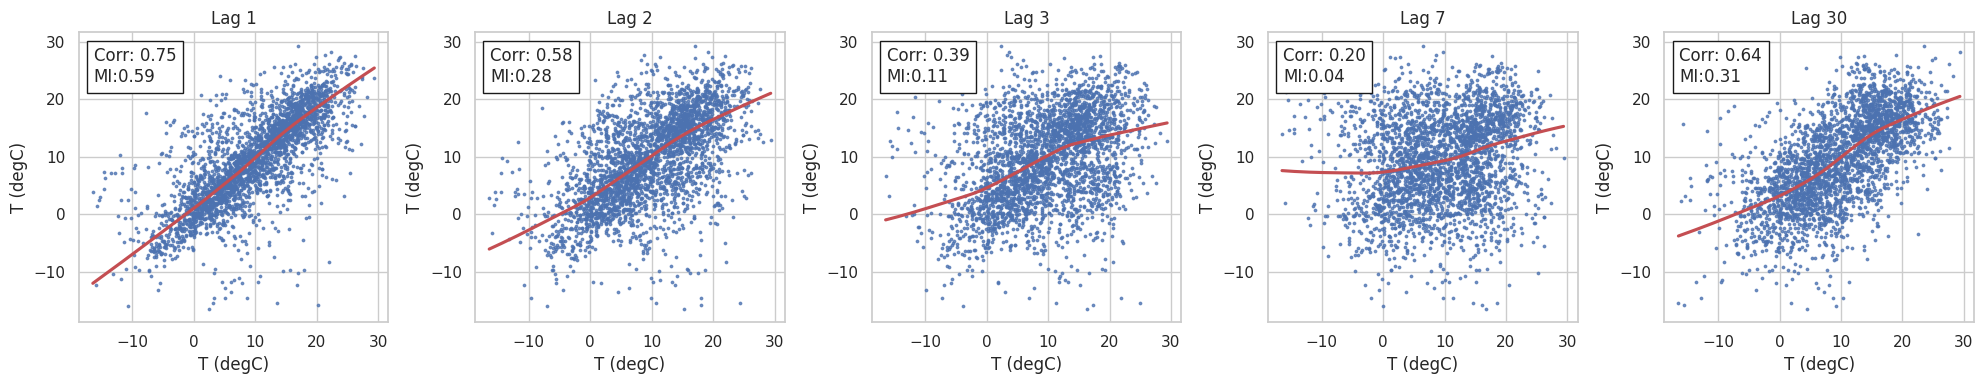

In [57]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, lag in enumerate([1, 2, 3, 7, 30]):
    lagplot(target.resample(rule='D').mean().dropna(), lag=lag, ax=axes[i])
plt.tight_layout()
plt.show()